# Fine tuning text embedding models using sentence_transformers

If you're building an LLM application your system will likely include a text embedding model that transforms written text into vector embeddings. These may be used for classification, routing, document retrieval, semantic caching or search.

One of the key measure of an embedding model is how well it can group semantically equivalent statements together, and similarly, how well it an distinguish between similar, but not equivalent statements.

Because embedding models are not performing logical reasoning, but instead are often used to perform vector similarity calculations, we're not guaranteed that every pair of similar vectors will be relevant or equivalent, or that embeddings that are far apart in vector space aren't relevant to each other. This is why using the correct text embedding model is critical. Using a text embedding model specifically fine tuned to correctly match queries for your system can improve your overall app performance.

This notebook uses the [sentence_transformers](https://sbert.net/) library to fine tune a text embedding model on a custom dataset.
The training method used is [contrastive fine tuning](https://arxiv.org/abs/2408.00690), where two statements are assigned a label as either being similar {label=1.0} or dissimilar {label=0.0}.
Training then proceeds to minimize the cosine distance between similar statements, and maximize the cosine distance between dissimilar statements.

This contrastive loss function is well suited to applications where we care about the metrics true positive, true negative, false positive, and false negative.

## Let's Begin!
<a href="https://colab.research.google.com/github/redis-developer/redis-ai-resources/blob/main/python-recipes/finetuning/00_text_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install  --quiet torch datasets sentence_transformers 'transformers[torch]' redisvl matplotlib seaborn scikit-learn ipywidgets


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


## Select our starting model and dataset to fine tune on
To perform finetuning you'll need a dataset that ideally is specific to your use case. For the type of training we'll be doing - contrastive fine tuning - you'll need to structure your dataset as a set of pairs of questions or statements and coresponding label indicating if they're equivalent or not.

An example of what this looks like is in `sample_dataset.csv`

| question_1 | question_2 | label |
|------------|------------|-------|
| What is AI? | What is artificial intelligence? | 1.0 |
| How to bake a cake? | How to make a sandwich? | 0.0 |
| Define machine learning. | Explain machine learning. | 1.0 |

In [2]:
# select the datasets to train and test on
# we've provided examples in the datasets directory of our public S3 bucket for what these files should look like
train_data = 'sample_dataset.csv'
test_data = 'sample_testset.csv'

In [3]:
import requests
import os

if not (os.path.exists(f"./datasets/{train_data}") and os.path.exists(f"./datasets/{test_data}")):
    if not os.path.exists('./datasets/'):
        os.mkdir('./datasets/')

    # download the files and save them locally
    for file in [train_data, test_data]:
        url = f'https://redis-ai-resources.s3.us-east-2.amazonaws.com/finetuning/datasets/{file}'
        r = requests.get(url)
        with open(f'./datasets/{file}', 'wb') as f:
            f.write(r.content)

In [4]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sentence_transformers.losses import ContrastiveLoss
import copy

# load a model to train/finetune
model_name = 'sentence-transformers/all-MiniLM-L6-v2'

model = SentenceTransformer(model_name)

# make a copy of the weights before training if we want to compare how much they've changed
before_training = copy.deepcopy(model.state_dict())

# this loss requires pairs of text and a floating point similarity score as a label
# we'll use 'hard labels' of 1.0 or 0.0 as that is shown to lead to the best separation
loss = ContrastiveLoss(model)

# load an example training dataset that works with our loss function:
train_dataset = load_dataset("csv", data_files=f"datasets/{train_data}", split='train')

## Define our training arguments

In [5]:
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers.training_args import BatchSamplers

args = SentenceTransformerTrainingArguments(
    # required parameters
    output_dir=f"models/trained_on_{train_data}",
    # optional training parameters
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_ratio=0.1,
    fp16=False,  # set to False if your GPU can't handle FP16
    bf16=False,  # set to True if your GPU supports BF16
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # losses using "in-batch negatives" benefit from no duplicates
    # optional tracking/debugging parameters
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    logging_steps=100,
    run_name=f"model-base-{train_data}",  # used in Weights & Biases if `wandb` is installed
)

## Split your dataset to perform training validation
While our model is training both the training loss and validation loss will be recorded. These are printed to `stdout`, and also logged in
`models/model-base-all/checkpoint-<step_num>/trainer_state.json`.

sentence_transformers uses the term 'evaluation' rather than 'validation'.

In [6]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction

# split the dataset into training and validation sets
train_dataset = train_dataset.train_test_split(train_size=0.8, seed=42)

validation_dataset = train_dataset['test']
train_dataset = train_dataset['train']

print('train', train_dataset)
print('validation', validation_dataset)

# initialize the evaluator
dev_evaluator = EmbeddingSimilarityEvaluator(
    sentences1=validation_dataset["question_1"],
    sentences2=validation_dataset["question_2"],
    scores=validation_dataset["label"],
    main_similarity=SimilarityFunction.COSINE,
    name=f"{train_data}-dev",
)

train Dataset({
    features: ['question_1', 'question_2', 'label'],
    num_rows: 41
})
validation Dataset({
    features: ['question_1', 'question_2', 'label'],
    num_rows: 11
})


## Train our model
This cell performs the full training for the number of epochs defined in our `SentenceTransformerTrainingArguments`, args. Losses are periodically printed out.

In [7]:
from sentence_transformers import SentenceTransformerTrainer

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    loss=loss,
    evaluator=dev_evaluator,
)
trainer.train()

# make a copy of the weights after training
after_training = copy.deepcopy(model.state_dict())

  0%|          | 0/3 [00:00<?, ?it/s]

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

{'train_runtime': 2.2703, 'train_samples_per_second': 18.06, 'train_steps_per_second': 1.321, 'train_loss': 0.03720299402872721, 'epoch': 1.0}


## That's it!
That is all it takes to produce a finetuned model on your dataset. Every application is different and you'll want to know how well this model can do with your system, and how much better it is now that you've tuned it. Here we compute some metrics to see the impact of fine tuning.
These will also help you choose the best similarity threshold for your app based on your criteria.

## Evaluate the trained model
As the ultimate goal of this fine tuning is to improve performance for distinguishing equivalent and not equivalent statements, we'll evaluate our trained model to to see how well it correctly identifies pairs of statements as either equivalent or not. We have a labeled dataset for this, where statements are known to be either equivalent, and labelled `1.0`, or not equivalent and labelled `0.0`. If you have a background in data science or statistics you may recognize this as a binary classification problem. Pairs embeddings will be classified as similar, aka positive, or dissimilar, aka negative. Comparing to our known labels that means that every pair of interest will in one of four groups:
- true positives (TP): our model correctly determines two vector embeddings are equivalent
- true negatives (TN): our model correctly determines two vector embeddings are different
- false positives (FP): our model incorrectly determines two vector embeddings are equivalent
- false negatives (FN): our model incorrectly determines two vector embeddings are different

Here we can also evaluate on different datasets we haven't trained on. We've again provided a `sample_testset.csv` file to illustrate this, but you should replace this with data relevant to your app.

In [8]:
import numpy as np

def evaluate_model(model, test_dataset):
    q1_embeddings = [model.encode(pair['question_1']) for pair in test_dataset]
    q2_embeddings = [model.encode(pair['question_2']) for pair in test_dataset]
    labels = [pair['label'] for pair in test_dataset]

    # compute all the distances between all the vectors for quicker reference later
    distances = np.empty(shape=(len(q1_embeddings), len(q2_embeddings)), dtype=np.float32, order='C')
    for index_1, embedding_1 in enumerate(q1_embeddings):
        for index_2, embedding_2 in enumerate(q2_embeddings):
            # compute cosine distance between embeddings
            cosine_distance = 1 - np.dot(embedding_1, embedding_2) / (np.linalg.norm(embedding_1) * np.linalg.norm(embedding_2))
            distances[index_1, index_2] = cosine_distance

    # for our range of thresholds see which embeddings fall within our threshold and so would be consindered equivalent
    metrics = {}
    thresholds = np.linspace(0.01, 0.6, 60)
    for threshold in thresholds:
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for index, label in enumerate(labels):
            # for question N find the most similar embedding, aka the one with the lowest distance
            distance_of_nearest = np.min(distances[index, :])
            index_of_nearest = np.argmin(distances[index, :])
            if distances[index, :][index_of_nearest] <= threshold: # if the distance is below our threshold our model thinks they're equivalent
                if label == 1: # check the label to see if it really is equivalent (label == 1) or if they're actually different (label == 0)
                    if index_of_nearest == index: # verify that we hit the correct matched pair, and not some other question
                        TP += 1 # we correctly found a matching entry
                    else:
                        FP += 1 # we found something we think is equivalent, but it's not what we should have found
                else:
                    FP += 1 # we think we found an equivalent statement, but shouldn't have
            else: # we didn't find anything
                if label == 1: # check it should be a miss
                    FN += 1 # we failed to find a matching pair
                else:
                    TN += 1 # correctly did not match any other embeddings

        F1 = (2 * TP) / (2 * TP + FP + FN)
        accuracy = (TP + TN) / len(test_dataset)
        metrics[threshold] = {"TP": TP, "TN": TN, "FP": FP, "FN": FN, "accuracy": accuracy, 'F1': F1}

    return metrics

## Perform our final comparison on our models before and after fine tuning

In [9]:
# load the test dataset
test_dataset = load_dataset("csv", data_files=f"datasets/{test_data}", split='train')

In [10]:
model.load_state_dict(before_training)
metrics_before_training = evaluate_model(model, test_dataset)

model.load_state_dict(after_training)
metrics_after_training = evaluate_model(model, test_dataset)

## Visualize metrics
Since we're tracking multiple metrics - true & false positives & negatives, accuracy and F1 score - we want a way to quickly visually compare all of these.
We'll plot these metrics to see how they change after fine tuning, and also how we can influence them by selecting the best cosine similarity threshold.

In [11]:
from matplotlib import pyplot as plt

def display_AUC(metrics_before, metrics_after):
    precision_before = [m['TP'] / (m['TP'] + m['FP']) if (m['TP'] + m['FP']) > 0 else 1 for m in metrics_before.values()]
    precision_after = [m['TP'] / (m['TP'] + m['FP']) if (m['TP'] + m['FP']) > 0 else 1 for m in metrics_after.values()]

    recall_before = [m['TP'] / (m['TP'] + m['FN']) if (m['TP'] + m['FN']) > 0 else 1 for m in metrics_before.values()]
    recall_after = [m['TP'] / (m['TP'] + m['FN']) if (m['TP'] + m['FN']) > 0 else 1 for m in metrics_after.values()]

    from sklearn.metrics import roc_auc_score
    y_true_before = []
    y_score_before = []
    y_true_after = []
    y_score_after = []

    for m in metrics_before.values():
        y_true_before.extend([1] * m['TP'] + [0] * m['FN'] + [0] * m['TN'] + [1] * m['FP'])
        y_score_before.extend([1] * m['TP'] + [1] * m['FN'] + [0] * m['TN'] + [0] * m['FP'])

    for m in metrics_after.values():
        y_true_after.extend([1] * m['TP'] + [0] * m['FN'] + [0] * m['TN'] + [1] * m['FP'])
        y_score_after.extend([1] * m['TP'] + [1] * m['FN'] + [0] * m['TN'] + [0] * m['FP'])

    auc_before = roc_auc_score(y_true_before, y_score_before)
    auc_after = roc_auc_score(y_true_after, y_score_after)

    plt.figure()
    plt.plot(recall_before, precision_before, scalex=False, scaley=False)
    plt.plot(recall_after, precision_after, scalex=False, scaley=False)
    plt.title(f'trained on {train_data}, test on {test_data}\n Precision Recall curves with finetuning')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0,1.1])
    plt.legend([f'before finetuning auc={auc_before :.4f}', f'after finetuning auc={auc_after :.4f}'])
    plt.show()


def display_accuracy(metrics_before, metrics_after):
    accuracy_before = [m['accuracy'] for m in metrics_before.values()]
    accuracy_after = [m['accuracy'] for m in metrics_after.values()]
    plt.figure()
    plt.plot(list(metrics_before.keys()), accuracy_before)
    plt.plot(list(metrics_after.keys()), accuracy_after)
    plt.title(f'trained on {train_data}, test on {test_data}\n Accuracy')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.ylim([0,1.1])
    plt.legend(['before finetuning', 'after finetuning'])
    plt.show()


def display_f1_score(metrics_before, metrics_after):
    F1_before = [m["F1"] for m in metrics_before.values()]
    F1_after = [m["F1"] for m in metrics_after.values()]

    plt.figure()
    plt.plot(list(metrics_before.keys()), F1_before)
    plt.plot(list(metrics_after.keys()), F1_after)
    plt.title(f'trained on {train_data}, test on {test_data}\n F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.legend(['before finetuning', 'after finetuning'])
    plt.show()

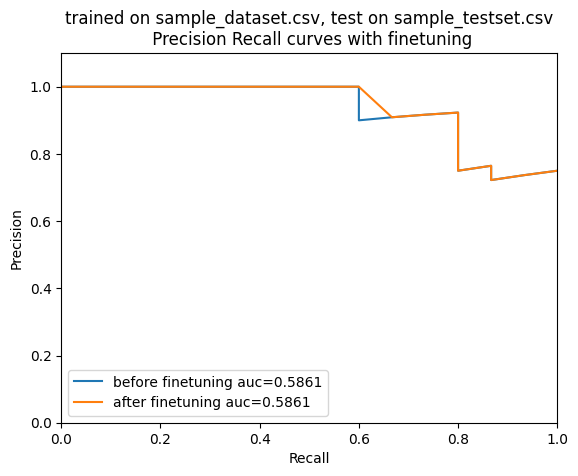

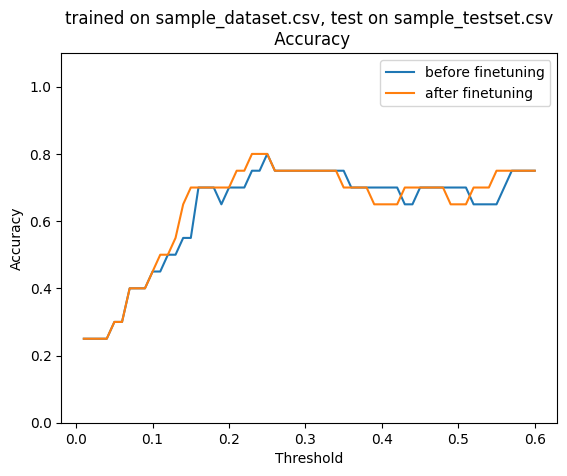

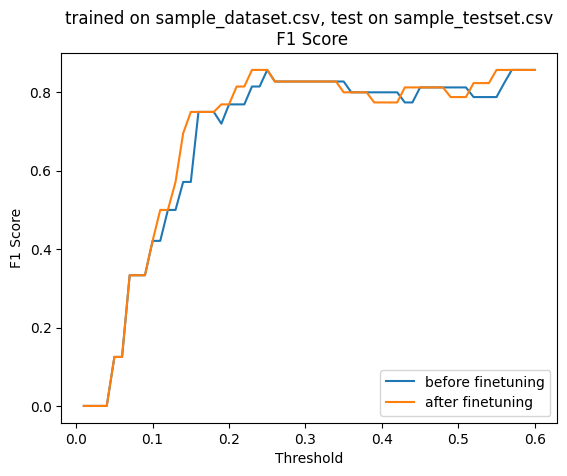

In [12]:
display_AUC(metrics_before_training, metrics_after_training)
display_accuracy(metrics_before_training, metrics_after_training)
display_f1_score(metrics_before_training, metrics_after_training)

## Every use case is different
With vector embeddings we always have to keep in mind there is a tradeoff between true and false positives and negatives. You can cast a wide net with a large threshold and grab many seemingly similar vectors at the risk of getting some irrelevant ones, or you can be conservative and match only highly similar embeddings, and risk missing something important. You can control this tradeoff by selecting the similarity threshold that makes sense for your system.

Where you set this threshold depends on your own use case and system, and your tolerance for different types of errors. Choosing the threshold that maximizes F1 score or accuracy are good places to start. Ultimately you'll want to optimize for your specific use case, and we have a [retrieval optimizer tool](https://github.com/redis-applied-ai/retrieval-optimizer) to help with that when you're ready for the next level of system improvements.

## Choosing your threshold
To get a sense of how the choice of similarity threshold changes cache performance here's an interactive tool that lets you change the threshold and immediately see how the tradeoff between true and false positives and negatives balances out.

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

def compute_metrics_at_threshold(
    scores: np.ndarray,
    labels: np.ndarray,
    threshold: float,
    high_score_more_similar: bool = True
):
    if high_score_more_similar:
        predictions = (scores >= threshold).astype(int)
    else:
        predictions = (scores <= threshold).astype(int)

    print(predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    cm = confusion_matrix(labels, predictions)

    return {'precision': precision, 'recall': recall, 'f1_score': f1, 'confusion_matrix': cm}


In [14]:
from sklearn.metrics.pairwise import cosine_similarity

q1_embeddings = [model.encode(pair['question_1']) for pair in test_dataset]
q2_embeddings = [model.encode(pair['question_2']) for pair in test_dataset]
cosine_similarities = np.array([cosine_similarity([emb1], [emb2])[0][0] for emb1, emb2 in zip(q1_embeddings, q2_embeddings)])
labels = np.array(test_dataset["label"])

In [15]:
import seaborn as sns
from ipywidgets import FloatSlider, Layout, interact
from IPython.display import display, HTML


def update_plots(threshold):
    # set a pleasing style and update global font sizes
    plt.rcParams.update({'font.size': 16})

    metrics = compute_metrics_at_threshold(cosine_similarities, labels, threshold, high_score_more_similar=True)
    precision = metrics['precision']
    recall_val = metrics['recall']
    f1 = metrics['f1_score']
    cm = metrics['confusion_matrix']

    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(labels, cosine_similarities)

    # clear previous plots
    plt.clf()

    # create subplots with a larger figure size for better readability
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Precision-Recall curve plot
    axs[0].plot(recall_curve, precision_curve, color='blue', linewidth=2, label='Precision-Recall Curve')
    axs[0].scatter(recall_val, precision, color='red', s=100, zorder=5,
                   label=(f'Threshold = {threshold:.4f}\n'
                          f'Precision = {precision:.2f}\n'
                          f'Recall = {recall_val:.2f}'))
    axs[0].set_title('Precision-Recall Curve', fontsize=20, fontweight='bold')
    axs[0].set_xlabel('Recall', fontsize=18)
    axs[0].set_ylabel('Precision', fontsize=18)
    axs[0].tick_params(axis='both', labelsize=16)
    axs[0].legend(fontsize=14)
    axs[0].grid(True, linestyle='--', alpha=0.7)

    # confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[1],
                cbar=True, annot_kws={'size': 16})
    axs[1].set_title('Confusion Matrix', fontsize=20, fontweight='bold')
    axs[1].set_xlabel('Predicted Label', fontsize=18)
    axs[1].set_ylabel('True Label', fontsize=18)
    axs[1].set_xticklabels(['Dissimilar (0)', 'Similar (1)'], fontsize=16)
    axs[1].set_yticklabels(['Dissimilar (0)', 'Similar (1)'], fontsize=16, rotation=0)

    # overall figure title with metrics
    fig.suptitle(
        (f'Cosine Similarity Threshold: {threshold:.4f}\n'
         f'Precision: {precision:.2f}, Recall: {recall_val:.2f}, F1 Score: {f1:.2f}'),
        fontsize=12, fontweight='bold'
    )

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# add some CSS to increase the font size for the slider's description and readout
display(HTML("""
<style>
    /* Style only the slider with the custom class 'custom-slider' */
    .custom-slider .widget-label {
        font-size: 20px !important;
        font-weight: bold;
    }
    .custom-slider .widget-readout {
        font-size: 18px !important;
    }
</style>
"""))

# add a slider with the new description and custom styling
threshold_slider = FloatSlider(
    value=np.median(cosine_similarities),
    min=np.min(cosine_similarities),
    max=np.max(cosine_similarities),
    step=0.001,
    description='Cosine Similarity Threshold:',
    readout=True,
    readout_format='.4f',
    continuous_update=False,
    style={'description_width': 'initial'},
    layout=Layout(width='80%', margin='20px 0px 20px 0px')
)

# add a custom class to the slider for our CSS targeting
threshold_slider.add_class("custom-slider")
interact(update_plots, threshold=threshold_slider)

interactive(children=(FloatSlider(value=0.8114206194877625, continuous_update=False, description='Cosine Simil…

<function __main__.update_plots(threshold)>